In [1]:
import GMMfunction as GMM
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import os
import subprocess # inkspace

import numpy as np
from scipy.optimize import minimize
# import seaborn as sns
# sns.set_style('white')
rd = 10
np.random.seed(rd)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmu-serif",
    "mathtext.fontset": "cm",
    "font.size": 16
})

# MACos only
# import os
# os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"


In [2]:
M, DX, DY, N, noise_level = (2, 2, 3, 10000, 2) # number of individual gaussians, dimension of the data, number of samples
mus = GMM.generate_mu_list(M, DX)
sigmas = GMM.generate_sigma_list(M, DX)
# mus = [np.array([1, 2]), np.array([8, 10])]
# sigmas = [np.array([[1, 0], [0, 2]]), np.array([[2, 1], [1, 1]])]
x = GMM.sample_multivariate_gaussian_mixture(mus, sigmas, N).T

A = np.array([[2, 0], [0, 1]])
A = np.random.randn(DY, DX)

Nsigma, n = GMM.generate_noise(noise_level, DY, N)

y = A @ x + n

train_samples_x = x[:, :int(x.shape[-1] * 0.8)]
test_samples_x  = x[:, int(x.shape[-1] * 0.8):]
train_samples_y = y[:, :int(y.shape[-1] * 0.8)]
test_samples_y  = y[:, int(y.shape[-1] * 0.8):]

Text(0.5, 1.0, '$p(x)$ vs $p(x|y)$')

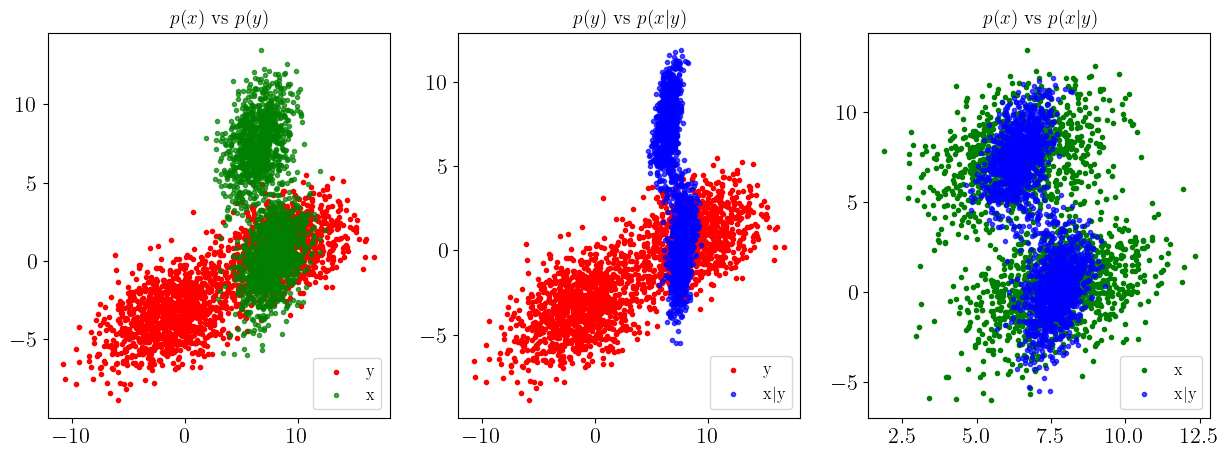

In [3]:

%matplotlib inline
mu1_real_res = GMM.mu1_real(test_samples_y, A, mus, sigmas, Nsigma)

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(test_samples_y[0], test_samples_y[1], marker='.', color='red', alpha=1, label='y')
# sns.scatterplot(test_samples_y, marker='.', color='red', alpha=1, label='y')
plt.scatter(test_samples_x[0], test_samples_x[1], marker='.', color='green', alpha=0.7, label='x')
plt.legend(loc='lower right', fontsize=12)
plt.title('$p(x)$ vs $p(y)$', fontsize=14)

plt.subplot(1, 3, 2)
plt.scatter(test_samples_y[0], test_samples_y[1], marker='.', color='red', alpha=1, label='y')
plt.scatter(mu1_real_res[0], mu1_real_res[1], marker='.', color='blue', alpha=0.7, label='x$|$y')
plt.legend(loc='lower right', fontsize=12)
plt.title('$p(y)$ vs $p(x|y)$', fontsize=14)

plt.subplot(1, 3, 3)
plt.scatter(test_samples_x[0], test_samples_x[1], marker='.', color='green', alpha=1, label='x')
plt.scatter(mu1_real_res[0], mu1_real_res[1], marker='.', color='blue', alpha=0.7, label='x$|$y')
plt.legend(loc='lower right', fontsize=12)
plt.title('$p(x)$ vs $p(x|y)$', fontsize=14)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


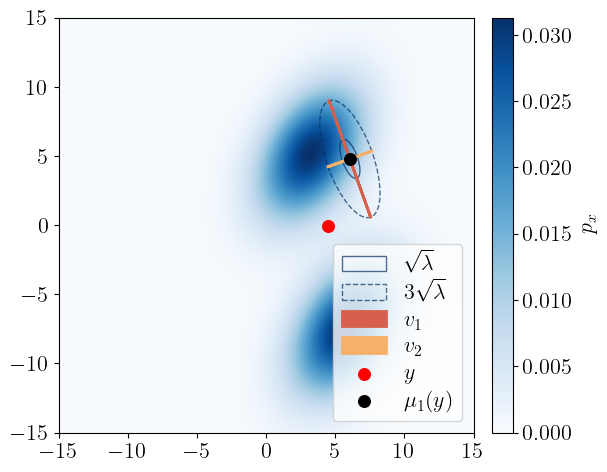

In [4]:
n_ev = 2 # number of eigenvectors

plt.figure(figsize=(6,5))

[XX, YY] = np.meshgrid(np.linspace(-4,13,100), np.linspace(-4,13,100))

xs = np.stack([XX.ravel(), YY.ravel()])
GMM_pdf, GMM_mean = GMM.px_pdf_real(xs, mus, sigmas)

x_1 = GMM_mean.reshape(-1,1)
# x_1 = np.array([-10, -10]).reshape(2,1).astype(np.float64)
# x_1 = np.array([4.5, 5]).reshape(2,1).astype(np.float64)
y_1 = A @ x_1 + GMM.generate_noise(noise_level, DY, 1)[1]
# y_1 = np.array([[3.5], [6.35]]).astype(np.float64)

first_moments, second_moments, eigvecs, eigvals, mmse = GMM.moment_calculation(y_1, A, mus, sigmas, Nsigma, n_ev)

c = plt.imshow(GMM_pdf.reshape(XX.shape), cmap='Blues', origin='lower', extent=[-15, 15, -15, 15], interpolation='bilinear')

angle = np.arctan2(eigvecs[1,0], eigvecs[0,0]) * 180 / np.pi
ellipse = patches.Ellipse((mmse[0,0], mmse[1,0]), 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), angle=angle,
                          fill=False, alpha=0.7, edgecolor='#053061', label='$\sqrt{\lambda}$')
plt.gca().add_artist(ellipse)

threesig_ellipse = patches.Ellipse((mmse[0,0], mmse[1,0]), 6 * np.sqrt(eigvals[0]), 6 * np.sqrt(eigvals[1]), angle=angle,
                          fill=False, alpha=0.7, edgecolor='#053061', linestyle='--', label='$3\sqrt{\lambda}$')
plt.gca().add_artist(threesig_ellipse)

eigvecs /= np.linalg.norm(eigvecs, axis=0, keepdims=True)
eigvals = np.abs(eigvals)

plt.arrow(mmse[0,0], mmse[1,0], eigvecs[0,0] * 3 * np.sqrt(eigvals[0]), eigvecs[1,0] * 3 * np.sqrt(eigvals[0]), head_length=0, color='#d6604d', linewidth=2, label='$v_1$')
plt.arrow(mmse[0,0], mmse[1,0], -eigvecs[0,0] * 3 * np.sqrt(eigvals[0]), -eigvecs[1,0] * 3 * np.sqrt(eigvals[0]), head_length=0, color='#d6604d', linewidth=2)
if n_ev > 1:
    plt.arrow(mmse[0,0], mmse[1,0], eigvecs[0,1] * 3 * np.sqrt(eigvals[1]), eigvecs[1,1] * 3 * np.sqrt(eigvals[1]), head_length=0, color='#f7b068', linewidth=2, label='$v_2$')
    plt.arrow(mmse[0,0], mmse[1,0], -eigvecs[0,1] * 3 * np.sqrt(eigvals[1]), -eigvecs[1,1] * 3 * np.sqrt(eigvals[1]), head_length=0, color='#f7b068', linewidth=2)
plt.scatter(y_1[0], y_1[1], marker='o', color='red', label='$y$', s=70)
plt.scatter(mmse[0], mmse[1], marker='o', color='black', label='$\mu_1(y)$', s=70)

y_up = (mmse + 3 * np.sqrt(eigvals) * eigvecs)[:,0]
y_down = (mmse - 3 * np.sqrt(eigvals) * eigvecs)[:, 0]

plt.colorbar(c, ax=plt.gca(), label="$p_x$", fraction=0.046, pad=0.04)

plt.legend(loc='lower right', labelspacing=0.3)
plt.tight_layout()
ylimmin, ylimmax = plt.gca().get_ylim()
xlimmin, xlimmax = plt.gca().get_xlim()
os.makedirs('Figures', exist_ok=True)
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.pdf'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.svg'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.eps'), dpi=500, bbox_inches='tight')
subprocess.call('inkscape Figures/GMM_Example_theoretical.svg --export-type="emf"',shell=True)

plt.show()

In [5]:

h=1e-5
A_invT = np.linalg.pinv(A.T)
third_moments = []
fourth_moments = []
for i in range(n_ev):
    first_term = GMM.mu1_real(y_1 + A @ eigvecs[:, i].reshape(2,1) * 2 * h, A, mus, sigmas, Nsigma)
    second_term = GMM.mu1_real(y_1 + A @ eigvecs[:, i].reshape(2,1) * h, A, mus, sigmas, Nsigma)
    third_term = GMM.mu1_real(y_1, A, mus, sigmas, Nsigma)
    fourth_term = GMM.mu1_real(y_1 - A @ eigvecs[:, i].reshape(2,1) * h, A, mus, sigmas, Nsigma)
    deriv_approx = (1/(h**3)) * (first_term - 3 * second_term + 3 * third_term - fourth_term)

    fourth_moments.append((noise_level ** 3) * (eigvecs[:, i] @ deriv_approx)[0] + 3 * (second_moments[i] ** 2))

    deriv_approx = (1/(h**2)) * (second_term - 2 * third_term + fourth_term)
    third_moments.append((noise_level ** 2) * (eigvecs[:, i] @ deriv_approx)[0])

first_moments = first_moments[:,0]
second_moments = np.abs(second_moments)
third_moments = np.array(third_moments)
fourth_moments = np.abs(np.array(fourth_moments))


print(f'vmu1 = {first_moments};')
print(f'vmu2 = {second_moments};')
print(f'vmu3 = {third_moments};')
print(f'vmu4 = {fourth_moments};')
print(f'noisy_sample = [{y_1[0,0]}; {y_1[1,0]}];')
print(f'mmse_sample = [{mmse[0,0]}; {mmse[1,0]}];')
print(f'real_sample = [{x_1[0,0]} {x_1[1,0]}];')
print(f'evs = {eigvecs};')



vmu1 = [2.47002563 7.31494996];
vmu2 = [2.21579965 0.3133214 ];
vmu3 = [-2.13470133e+00  3.34605040e-05];
vmu4 = [10.42527481 35.55406447];
noisy_sample = [4.504361171612999; -0.08410881805360848];
mmse_sample = [6.059281575269877; 4.784832950287949];
real_sample = [7.024844390965107 3.8477791594900665];
evs = [[-0.33609116  0.94182946]
 [ 0.94182946  0.33609116]];


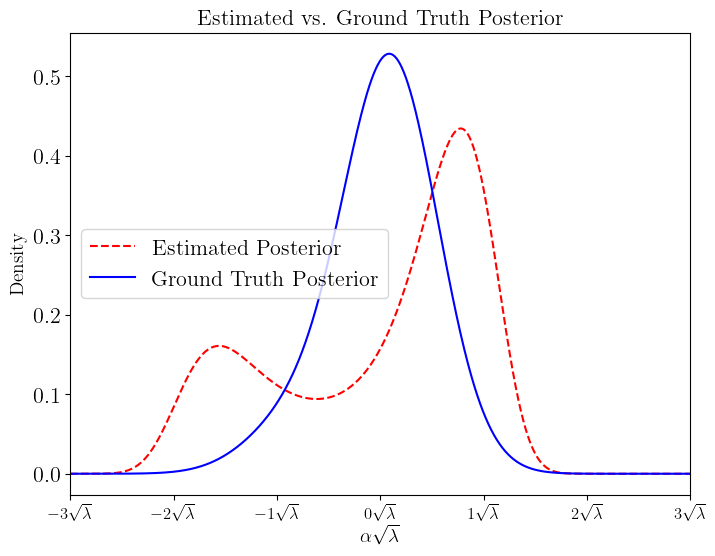

In [6]:
from scipy.stats import norm

def posterior_density(x):
    return np.exp(z_opt[0] + z_opt[1] * x + z_opt[2] * (x - vmu1[i])**2 +
                   z_opt[3] * (x - vmu1[i])**3 + z_opt[4] * (x - vmu1[i])**4)

def objective(z):
    term1 = -(z[0] + z[1] * vmu1[i] + z[2] * vmu2[i] + z[3] * vmu3[i] + z[4] * vmu4[i])
    term2 = delta_opt * np.sum(np.exp(
        z[0] + z[1] * proj_xs + z[2] * (proj_xs - vmu1[i])**2 +
        z[3] * (proj_xs - vmu1[i])**3 + z[4] * (proj_xs - vmu1[i])**4
    ))
    return term1 + term2

def project_gmm_pdf(draw_xs, mus, sigmas, v):

    v = v / np.linalg.norm(v)
    M = len(mus)
    projected_pdf = np.zeros_like(draw_xs, dtype=np.float64)

    for i in range(M):
        mu_proj = np.dot(v, mus[i])
        sigma_proj = np.sqrt(np.dot(v.T, np.dot(sigmas[i], v)))

        projected_pdf += norm.pdf(draw_xs, loc=mu_proj, scale=sigma_proj)

    return projected_pdf

delta_opt = 0.005
delta = 0.005
bit = 0.5
howmuch = 20

vmu1 = np.array(first_moments)
vmu2 = np.array(second_moments)
vmu3 = np.array(third_moments)
vmu4 = np.array(fourth_moments)

i = 0
proj_xs = np.arange(vmu1[i] - howmuch, vmu1[i] + howmuch, delta_opt)

z_init = np.zeros(5)
result = minimize(objective, z_init, method='L-BFGS-B', options={'maxfun': 6000})
z_opt = result.x

yup3 = vmu1[i] + 3 * np.sqrt(vmu2[i])
ydown3 = vmu1[i] - 3 * np.sqrt(vmu2[i])
abit = bit * np.sqrt(vmu2[i])

less_proj_noncentered_xs = np.arange(ydown3 - abit, yup3 + abit, delta)
func_pdf = posterior_density(less_proj_noncentered_xs)
func_pdf /= delta * np.sum(func_pdf)

projected_pdf = GMM.x_given_y_v(less_proj_noncentered_xs, y_1 , mus, sigmas, A, Nsigma, eigvecs[:, 0])

sigma_1 = np.sqrt(second_moments[0])  # 1-sigma
sigma_2 = 2 * sigma_1  # 2-sigma
sigma_3 = 3 * sigma_1  # 3-sigma
tick_labels = [r'$-3 \sqrt{\lambda}$', r'$-2 \sqrt{\lambda}$', r'$-1 \sqrt{\lambda}$', r'$0 \sqrt{\lambda}$', r'$1 \sqrt{\lambda}$', r'$2 \sqrt{\lambda}$', r'$3 \sqrt{\lambda}$']
tick_positions = [vmu1[i]-sigma_3, vmu1[i]-sigma_2, vmu1[i]-sigma_1, vmu1[i], vmu1[i]+sigma_1, vmu1[i]+sigma_2, vmu1[i]+sigma_3]

plt.figure(figsize=(8, 6))
plt.plot(less_proj_noncentered_xs, func_pdf, 'r--', label="Estimated Posterior")
plt.plot(less_proj_noncentered_xs, projected_pdf.squeeze(), 'b-', label="Ground Truth Posterior")
plt.xticks(tick_positions, tick_labels, fontsize=12)
plt.xlim(vmu1[i] - sigma_3, vmu1[i] + sigma_3) 
plt.xlabel(r'$\alpha \sqrt{\lambda}$', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Estimated vs. Ground Truth Posterior', fontsize=16)
plt.legend()

plt.show()